In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [2]:
file_path = "../../df_naive_impute.csv"
# df = pd.read_csv(file_path, skiprows=[1])
df = pd.read_csv(file_path)

In [3]:
df.columns, len(df.columns)

(Index(['Dati', 'Time', 'DEPTH', 'ENGINE_1_FLOWTEMPA',
        'ENGINE_1_FUEL_CONSUMPTION', 'ENGINE_2_FLOWTEMPA',
        'ENGINE_2_FUEL_CONSUMPTION', 'HEADING', 'LATITUDE', 'LONGITUDE',
        'PITCH_1', 'PITCH_2', 'POWER_1', 'POWER_2', 'SOG', 'SOG_SPEEDLOG_LONG',
        'SOG_SPEEDLOG_TRANS', 'SPEED_1', 'SPEED_2', 'STW', 'THRUST_1',
        'THRUST_2', 'TORQUE_1', 'TORQUE_2', 'WIND_ANGLE', 'WIND_SPEED',
        'WIND_ANGLE_TRUE', 'WIND_SPEED_TRUE', 'trip_id'],
       dtype='object'),
 29)

In [4]:
# naive mode definition
df["POWER_1"] = df["POWER_1"].astype(float)
df["POWER_2"] = df["POWER_2"].astype(float)
df["STW"] = df["STW"].astype(float)
df["STW_diff"] = abs(df["STW"] - df["STW"].shift(periods=-1, fill_value=100))

# MODE for operation mode: 1 for mode1, 2 for mode2, 0 for unknown(power with nan)
def naive_operation_mode(row):
    if pd.isna(row['POWER_1']) or (pd.isna(row["POWER_2"])):
        return 0
    elif (~((row["POWER_1"]<=800) ^ (row["POWER_2"]<=800))) | (row["STW"]<=16) | (row["STW_diff"]>=1):
        return 2
    else:
        return 1

df["MODE"] = df[["POWER_1", "POWER_2", "STW", "STW_diff"]].apply(naive_operation_mode, axis=1)
df.drop("STW_diff", axis=1, inplace=True)

In [5]:
def correct_mode(row):
    if (row["MODE"]==1):
        if row["trip_id"]==0:
            return 2
    return row["MODE"]

def clean_mode(row):
    if row["MODE_up"] == row["MODE_down"]:
        if row["MODE"]!=row["MODE_up"]:
            return row["MODE_up"]
    return row["MODE"]

df["MODE"] = df[["MODE", "STW", "DEPTH", "trip_id"]].apply(correct_mode,axis=1)
df["MODE_up"] = df["MODE"].shift(periods=-1)
df["MODE_down"] = df["MODE"].shift(periods=1)
df["MODE"] = df[["MODE", "MODE_up", "MODE_down"]].apply(clean_mode,axis=1)
df.drop(["MODE_up", "MODE_down"],axis=1, inplace=True)

In [6]:
df[df.trip_id==1119][["SPEED_1", "SPEED_2", "STW", "MODE"]].to_csv("tmp.csv", index=False)

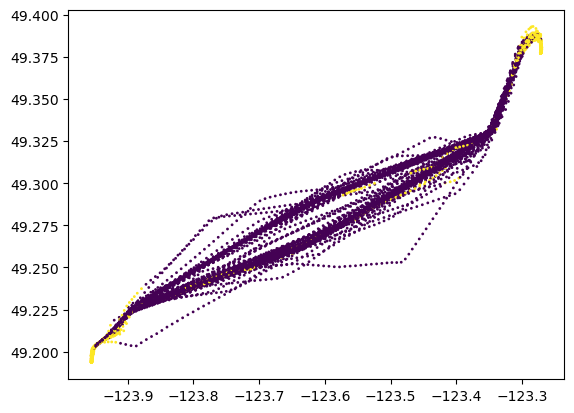

In [61]:
samples = df.trip_id.sample(100)
plt.scatter(df[df.trip_id.isin(samples)].LONGITUDE, df[df.trip_id.isin(samples)].LATITUDE, c = df[df.trip_id.isin(samples)].MODE, s=1)

In [62]:
df.groupby("MODE").count()

,Dati,Time,DEPTH,ENGINE_1_FLOWTEMPA,ENGINE_1_FUEL_CONSUMPTION,ENGINE_2_FLOWTEMPA,ENGINE_2_FUEL_CONSUMPTION,HEADING,LATITUDE,LONGITUDE,...,STW,THRUST_1,THRUST_2,TORQUE_1,TORQUE_2,WIND_ANGLE,WIND_SPEED,WIND_ANGLE_TRUE,WIND_SPEED_TRUE,trip_id
MODE,,,,,,,,,,,,,,,,,,,,,
1.0,271017,271017,271017,271017,271017,271017,271017,271017,271017,271017,...,271017,271017,271017,271017,271017,271017,271017,271017,271017,271017
2.0,53238,53238,53238,53238,53238,53238,53238,53238,53238,53238,...,53238,53238,53238,53238,53238,53238,53238,53238,53238,53238


In [133]:
# from the Dati variable, get the corresponding season code, hour, and day of the week
def get_dt_info(minute, starting_dt):
    dt = starting_dt + datetime.timedelta(minutes=minute) # days, seconds, then other fields.
    month = dt.month
    season = get_season(month)
    hour = dt.hour
    weekday = dt.weekday()
    return dt, season, hour, weekday

# get season code from corresponding month:
# spring: 0, summer: 1, fall: 2, winter: 3
def get_season(month):
    if month <= 3:
        return 3
    elif month <=6:
        return 0
    elif month <=9:
        return 1
    else:
        return 2

# convert Dati to python datetime format
# df["datetime"] = pd.to_datetime(df.Dati, format='%y%m%d_%H%M%S')
# df.dropna(subset = ["Time"], inplace=True)
starting_dt = pd.to_datetime(df.iloc[0].Dati, format='%y%m%d_%H%M%S')
df["datetime"],df["season"], df["hour"], df["weekday"] = zip(*df["Time"].apply(get_dt_info, starting_dt = starting_dt))
# df["datetime"] = pd.to_datetime(df.Dati, format='%y%m%d_%H%M%S')
df[["datetime", "season", "hour", "weekday"]]

,datetime,season,hour,weekday
0,2019-08-30 04:54:00,1,4,4
1,2019-08-30 04:55:00,1,4,4
2,2019-08-30 04:56:00,1,4,4
3,2019-08-30 04:57:00,1,4,4
4,2019-08-30 04:58:00,1,4,4
...,...,...,...,...
324250,2021-10-01 00:34:00,2,0,4
324251,2021-10-01 00:35:00,2,0,4
324252,2021-10-01 00:36:00,2,0,4
324253,2021-10-01 00:37:00,2,0,4


In [134]:
df.trip_id.unique()

array([   2,    4,    5, ..., 4078, 4080, 4082])

In [139]:
df[df.trip_id==5][["datetime", "weekday"]]

,datetime,weekday
211,2019-08-30 17:03:00,4
212,2019-08-30 17:04:00,4
213,2019-08-30 17:05:00,4
214,2019-08-30 17:06:00,4
215,2019-08-30 17:07:00,4
...,...,...
312,2019-08-30 18:44:00,4
313,2019-08-30 18:45:00,4
314,2019-08-30 18:46:00,4
315,2019-08-30 18:47:00,4


In [64]:
# current: difference between STW and SOG
df["current"] = df["STW"] - df["SOG"]
# df.current

In [65]:
# # Horseshoe Bay
# # 49.3771, -123.2715
# H_lat = 49.3771
# H_long = -123.2715

# # Nanaimo 
# # 49.1936, -123.9554
# N_lat = 49.1936
# N_long = -123.9554

In [66]:
def get_direction():
    trips = list(df.trip_id.unique())
    # trip 0 (parking) has direction 0
    direction_dict = {}
    direction_dict[0] = "parking"
    for trip in trips:
        tmp_df = df[df.trip_id==trip].reset_index()
        if (tmp_df.iloc[-1].LONGITUDE > tmp_df.iloc[0].LONGITUDE) & (tmp_df.iloc[-1].LATITUDE > tmp_df.iloc[0].LATITUDE):
            direction_dict[trip]="N-H"
        elif (tmp_df.iloc[-1].LONGITUDE < tmp_df.iloc[0].LONGITUDE) & (tmp_df.iloc[-1].LATITUDE < tmp_df.iloc[0].LATITUDE):
            direction_dict[trip]="H-N"
        else:
            print("error occurs when classifying trip {}".format(trip))
    return direction_dict

In [67]:
direcs_dict = get_direction()
df["direction"] = df["trip_id"].apply(lambda x: direcs_dict[x])
df.groupby("direction").count()

,Dati,Time,DEPTH,ENGINE_1_FLOWTEMPA,ENGINE_1_FUEL_CONSUMPTION,ENGINE_2_FLOWTEMPA,ENGINE_2_FUEL_CONSUMPTION,HEADING,LATITUDE,LONGITUDE,...,WIND_SPEED,WIND_ANGLE_TRUE,WIND_SPEED_TRUE,trip_id,MODE,datetime,season,hour,weekday,current
direction,,,,,,,,,,,,,,,,,,,,,
H-N,115157,115157,115157,115157,115157,115157,115157,115157,115157,115157,...,115157,115157,115157,115157,115157,115157,115157,115157,115157,115157
N-H,209098,209098,209098,209098,209098,209098,209098,209098,209098,209098,...,209098,209098,209098,209098,209098,209098,209098,209098,209098,209098


In [68]:
df.groupby("direction").trip_id.nunique()

direction
H-N    1114
N-H    2012
Name: trip_id, dtype: int64

In [69]:
# # 0: H, 1: N, 2: H-N, 3: N-H
# def get_direction():
#     direc = np.zeros(df.shape[0])
#     direc[0] = 0
#     for i in range(1, df.shape[0]):
#         if (df.iloc[i].LONGITUDE == H_long) and (df.iloc[i].LATITUDE == H_lat) and (df.iloc[i].SOG < 0.1):
#             direc[i]=0
#         elif (df.iloc[i].LONGITUDE == N_long) and (df.iloc[i].LATITUDE == N_lat) and (df.iloc[i].SOG < 0.1):
#             direc[i]=1
#         elif direc[i-1] == 0:
#             direc[i]=2
#         elif direc[i-1] == 1:
#             direc[i]=3
#         else:
#             direc[i] = (direc[i-1])
#     return direc
# direcs = get_direction()

In [70]:
# df["direction"] = direcs
# df["direction"].value_counts()

In [71]:
# weather related features
# temperature, humidity, pressure, precipitation, rain, snowfall
# weathercode: uses WMO weather codes

weather = pd.read_csv("weather.csv")
weather.columns = ["time", "pressure", "rain", "snowfall", "weathercode"]
weather["time"] = pd.to_datetime(weather["time"], format='%Y-%m-%dT%H:%M')
weather["day"] = weather.time.apply(lambda x: x.date())
weather["hour"] = weather.time.apply(lambda x: x.hour)

df["day"] = df.datetime.apply(lambda x: x.date())
df["hour"] = df.datetime.apply(lambda x: x.hour)
df = pd.merge(df, weather, on=["day", "hour"], how="left").drop(["day", "hour", "time"], axis=1)

In [72]:
holidays = []
holidays.append(datetime.datetime(2019, 9, 2))
holidays.append(datetime.datetime(2019, 10, 14))
holidays.append(datetime.datetime(2019, 11, 11))
holidays.append(datetime.datetime(2019, 12, 25))
holidays.append(datetime.datetime(2020, 1, 1))
holidays.append(datetime.datetime(2020, 2, 17))
holidays.append(datetime.datetime(2020, 4, 10))
holidays.append(datetime.datetime(2020, 5, 18))
holidays.append(datetime.datetime(2020, 7, 1))
holidays.append(datetime.datetime(2020, 8, 3))
holidays.append(datetime.datetime(2020, 9, 7))
holidays.append(datetime.datetime(2020, 10, 12))
holidays.append(datetime.datetime(2020, 11, 11))
holidays.append(datetime.datetime(2020, 12, 25))
holidays.append(datetime.datetime(2021, 1, 1))
holidays.append(datetime.datetime(2021, 2, 15))
holidays.append(datetime.datetime(2021, 4, 2))
holidays.append(datetime.datetime(2021, 5, 24))
holidays.append(datetime.datetime(2021, 7, 1))
holidays.append(datetime.datetime(2021, 8, 2))
holidays.append(datetime.datetime(2021, 9, 6))
is_holiday = [1 for i in range(len(holidays))]
holidays = pd.DataFrame({"date":holidays, "holiday":is_holiday})
holidays["date"] = holidays["date"].apply(lambda x: x.date())

In [73]:
df["date"] = df.datetime.apply(lambda x: x.date())
df = pd.merge(df, holidays, on="date", how="left")
df["holiday"] = df["holiday"].fillna(0)
df["is_weekday"] = (df["weekday"]>0) & (df["weekday"]<=5) & (~(df["holiday"]==1))
df = df.drop(["date","holiday"], axis=1)

In [74]:
def get_wind_direction(angle):
    angle = np.abs(angle)
    if angle <= 60:
        return 0
    elif angle <= 120:
        return 1
    elif angle <= 180:
        return 2
    else:
        return np.nan
    
df["wind_force"] = df["WIND_SPEED_TRUE"] ** 2
df["wind_direc"] = df["WIND_ANGLE"].apply(get_wind_direction)

In [75]:
df["effective_wind_factor"] = df[["HEADING", "WIND_ANGLE"]].apply(lambda x: np.cos((x["HEADING"]-x["WIND_ANGLE"])*np.pi/180), axis=1)
df["effective_wind"] = df["WIND_SPEED"] * df["effective_wind_factor"]

In [76]:
df["resist_ratio1"] = df["THRUST_1"]/(df["TORQUE_1"]*df["SPEED_1"]+1e-6)
df["resist_ratio2"] = df["THRUST_2"]/(df["TORQUE_2"]*df["SPEED_2"]+1e-6)

In [77]:
def mode_change_inbetween(df, speed_thresh=10):
    trip_lists = []
    for trip_id in list(df.trip_id.unique()):
        tmp_df = df[df.trip_id==trip_id]
        tmp_df = tmp_df[(tmp_df.LONGITUDE>-123.8) & (tmp_df.LONGITUDE<-123.4)]
        tmp_df["MODE_diff"] = abs(tmp_df["MODE"]-tmp_df["MODE"].shift(periods=-1))
        mode_change = tmp_df["MODE_diff"].sum()
        if mode_change > 0:
            trip_lists.append(trip_id)
        # if (tmp_df.mode<speed_thresh).sum()>0:
            # trip_lists.append(trip_id)
    return trip_lists
        
def travel_distance(df, thresh = 1.3):
    trip_distance = {}
    for trip_id in list(df.trip_id.unique()):
        tmp_df = df[df.trip_id==trip_id]
        tmp_df["LONGITUDE_up"] = tmp_df["LONGITUDE"].shift(periods=-1, fill_value=tmp_df.iloc[-1].LONGITUDE)
        tmp_df["LATITUDE_up"] = tmp_df["LATITUDE"].shift(periods=-1, fill_value=tmp_df.iloc[-1].LATITUDE)
        tmp_df["distance"] = ((tmp_df["LONGITUDE_up"]-tmp_df["LONGITUDE"])**2 + (tmp_df["LATITUDE_up"]-tmp_df["LATITUDE"])**2)**0.5
        trip_distance[trip_id] = tmp_df["distance"].sum()
    mean = np.mean(list(trip_distance.values()))
    std = np.std(list(trip_distance.values()))
    threshold = mean + std * thresh
    rerout_list = []
    for _, (trip, dist) in enumerate(trip_distance.items()):
        if dist > threshold:
            rerout_list.append(trip)
    return (rerout_list)

def get_adversarial(df):
    reduce_speed = mode_change_inbetween(df)
    reroute = travel_distance(df)
    adversarial = list(set(reduce_speed+reroute))
    return adversarial, reroute, reduce_speed

In [78]:
adversarial, reroute, reduce_speed = get_adversarial(df)
df["adversarial"] = df["trip_id"].apply(lambda x: 1 if x in adversarial else 0)


/Users/yim/.local/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/yim/.local/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/yim/.local/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

In [79]:
len(adversarial)

320

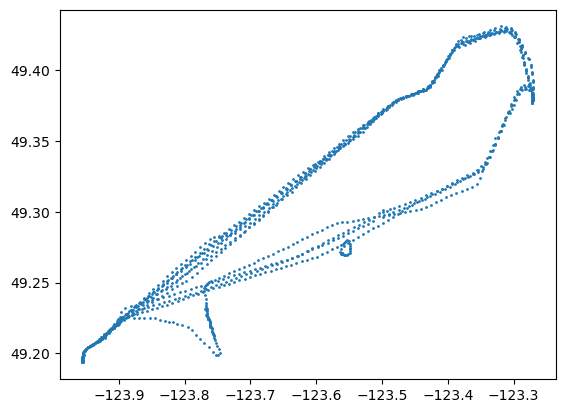

In [80]:
samples = reroute
plt.scatter(df[df.trip_id.isin(samples)].LONGITUDE, df[df.trip_id.isin(samples)].LATITUDE, s=1)

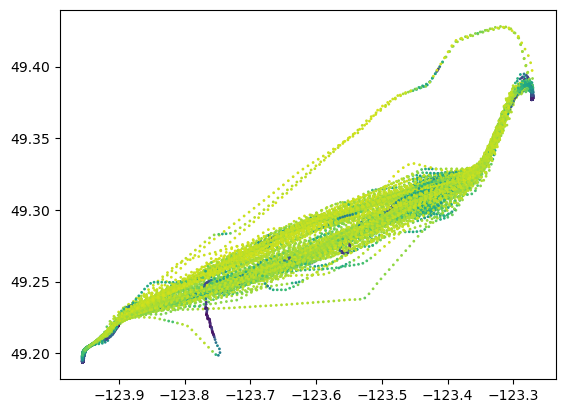

In [81]:
samples = reduce_speed
plt.scatter(df[df.trip_id.isin(samples)].LONGITUDE, df[df.trip_id.isin(samples)].LATITUDE, c = df[df.trip_id.isin(samples)].STW, s=1)

In [82]:
df.to_csv("../../feature1.csv", index=False)

In [89]:
len(df[pd.isna(df)].trip_id)

324255

In [98]:
df

,Dati,Time,DEPTH,ENGINE_1_FLOWTEMPA,ENGINE_1_FUEL_CONSUMPTION,ENGINE_2_FLOWTEMPA,ENGINE_2_FUEL_CONSUMPTION,HEADING,LATITUDE,LONGITUDE,...,snowfall,weathercode,is_weekday,wind_force,wind_direc,effective_wind_factor,effective_wind,resist_ratio1,resist_ratio2,adversarial
0,190830_022700,147.0,0.0049,25.6000,332.9910,25.6000,334.3725,176.4,49.1936,-123.9554,...,0.0,1,True,20.241001,2.0,0.954240,5.346895,0.002412,0.0,0
1,190830_022800,148.0,0.0037,25.6083,401.2981,25.6000,383.3828,179.7,49.1943,-123.9554,...,0.0,1,True,96.012562,1.0,0.178802,0.641006,0.001969,0.0,0
2,190830_022900,149.0,0.0158,25.7000,423.8546,25.6417,424.2150,186.9,49.1965,-123.9555,...,0.0,1,True,278.439282,0.0,-0.969872,-5.510522,0.001711,0.0,0
3,190830_023000,150.0,0.0206,25.7867,561.3356,25.7100,536.0195,215.1,49.1994,-123.9543,...,0.0,1,True,445.691210,0.0,-0.992757,-7.372911,0.001434,0.0,0
4,190830_023100,151.0,0.0215,25.9300,648.2187,25.8250,615.8354,232.2,49.2024,-123.9504,...,0.0,1,True,1002.317608,0.0,-0.949972,-14.854428,0.001337,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324250,210930_185100,1098607.0,0.0000,27.1217,593.1966,27.1767,691.1131,290.0,49.3878,-123.2782,...,0.0,1,True,1395.000090,0.0,-0.438371,-11.056466,0.001444,0.0,0
324251,210930_185200,1098608.0,0.0000,27.7767,552.8069,27.7633,631.1689,327.1,49.3859,-123.2733,...,0.0,1,True,1620.988382,0.0,0.755853,20.052793,0.001489,0.0,0
324252,210930_185300,1098609.0,0.0002,27.9600,182.8802,27.9667,253.8338,357.7,49.3823,-123.2714,...,0.0,1,True,1589.405162,NaN,0.996637,22.978283,0.001192,0.0,0
324253,210930_185400,1098610.0,0.0004,26.7883,309.7972,27.1283,369.1019,0.9,49.3797,-123.2713,...,0.0,1,True,283.821409,0.0,0.919821,10.317362,0.002459,0.0,0


In [31]:
df.columns

Index(['Dati', 'Time', 'DEPTH', 'ENGINE_1_FLOWTEMPA',
       'ENGINE_1_FUEL_CONSUMPTION', 'ENGINE_2_FLOWTEMPA',
       'ENGINE_2_FUEL_CONSUMPTION', 'HEADING', 'LATITUDE', 'LONGITUDE',
       'PITCH_1', 'PITCH_2', 'POWER_1', 'POWER_2', 'SOG', 'SOG_SPEEDLOG_LONG',
       'SOG_SPEEDLOG_TRANS', 'SPEED_1', 'SPEED_2', 'STW', 'THRUST_1',
       'THRUST_2', 'TORQUE_1', 'TORQUE_2', 'WIND_ANGLE', 'WIND_SPEED',
       'WIND_ANGLE_TRUE', 'WIND_SPEED_TRUE', 'trip_id', 'MODE', 'datetime',
       'season', 'weekday', 'current', 'direction', 'pressure', 'rain',
       'snowfall', 'weathercode', 'is_weekday', 'effective_wind_factor',
       'effective_wind', 'resist_ratio1', 'resist_ratio2', 'adversarial'],
      dtype='object')

In [20]:
df = pd.read_csv("../../feature1.csv")

def plot_location(samples, column, s=1):
    plt.scatter(samples.LONGITUDE, samples.LATITUDE, c = samples[column], s=1)
    plt.colorbar(fraction=0.046, pad=0.04).ax.tick_params(labelsize=7, rotation=90)
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7,rotation=90)
    plt.title("location vs. {}".format(column), fontsize=7)

In [9]:
sample_size=20
sample_trips = df.trip_id.sample(sample_size)
samples = df[df.trip_id.isin(sample_trips)]

/Users/yim/.local/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == "":


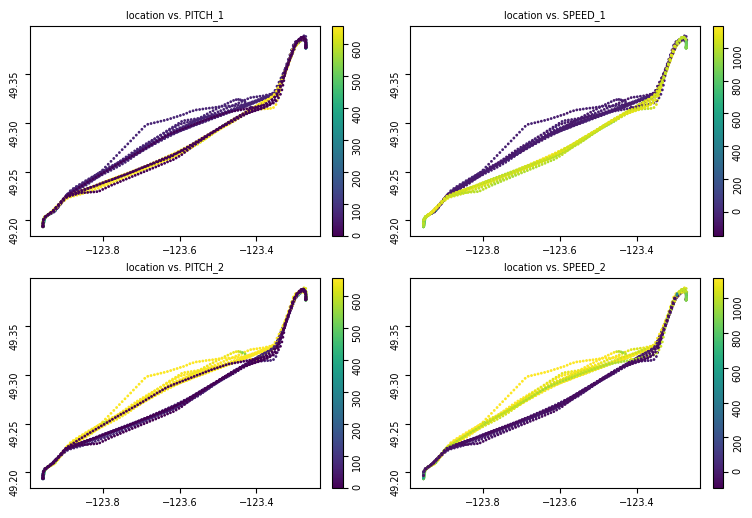

In [113]:
fig = plt.figure(figsize=(9,6))

fig.add_subplot(2,2,1)
plot_location(samples, "PITCH_1", s=1)
fig.add_subplot(222)
plot_location(samples, "SPEED_1", s=1)
fig.add_subplot(223)
plot_location(samples, "PITCH_2", s=1)
fig.add_subplot(224)
plot_location(samples, "SPEED_2", s=1)

fig.show()

/Users/yim/.local/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


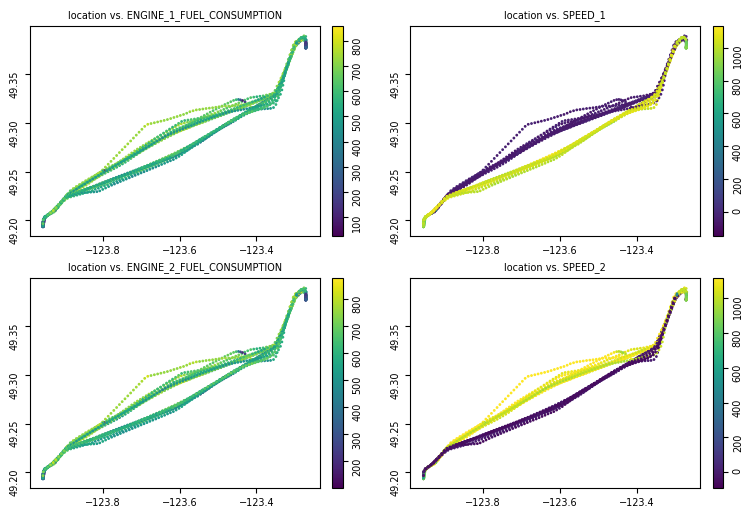

In [114]:
fig = plt.figure(figsize=(9,6))
fig.add_subplot(2,2,1)
plot_location(samples, "ENGINE_1_FUEL_CONSUMPTION", s=1)
fig.add_subplot(222)
plot_location(samples, "SPEED_1", s=1)
fig.add_subplot(223)
plot_location(samples, "ENGINE_2_FUEL_CONSUMPTION", s=1)
fig.add_subplot(224)
plot_location(samples, "SPEED_2", s=1)

fig.show()

In [139]:
df.columns

Index(['Dati', 'Time', 'CARGO', 'CARGO_PAX', 'DEPTH', 'ENGINE_1_FLOWRATE',
       'ENGINE_1_FLOWRATEA', 'ENGINE_1_FLOWRATEB', 'ENGINE_1_FLOWTEMPA',
       'ENGINE_1_FLOWTEMPB', 'ENGINE_1_FUEL_CONSUMPTION', 'ENGINE_2_FLOWRATE',
       'ENGINE_2_FLOWRATEA', 'ENGINE_2_FLOWRATEB', 'ENGINE_2_FLOWTEMPA',
       'ENGINE_2_FLOWTEMPB', 'ENGINE_2_FUEL_CONSUMPTION', 'HEADING',
       'LATITUDE', 'LONGITUDE', 'PAX', 'PITCH_1', 'PITCH_2', 'POWER_1',
       'POWER_2', 'RATE_OF_TURN', 'SOG', 'SOG_SPEEDLOG_LONG',
       'SOG_SPEEDLOG_TRANS', 'SPEED_1', 'SPEED_2', 'STW', 'THRUST_1',
       'THRUST_2', 'TORQUE_1', 'TORQUE_2', 'TRACK_MADE_GOOD', 'WIND_ANGLE',
       'WIND_SPEED', 'WIND_ANGLE_TRUE', 'WIND_SPEED_TRUE', 'trip_id'],
      dtype='object')

In [130]:
df = pd.read_csv("../../df_cleaned_location.csv")
tmp = df[df.trip_id==101]
tmp = tmp[["HEADING", "RATE_OF_TURN"]]
tmp["TURN"] = tmp.RATE_OF_TURN*60
tmp["HEADING_from_TURN"] = tmp["TURN"] + tmp["HEADING"]
tmp["HEADING_from_TURN"] = tmp["HEADING_from_TURN"].shift(1)
tmp

,HEADING,RATE_OF_TURN,TURN,HEADING_from_TURN
17944,4.7,0.0068,0.408,NaN
17945,5.1,-0.0024,-0.144,5.108
17946,5.0,-0.2062,-12.372,4.956
17947,347.4,-0.8100,-48.600,-7.372
17948,298.9,-0.7811,-46.866,298.800
...,...,...,...,...
18044,212.3,-0.3264,-19.584,211.574
18045,194.4,-0.0391,-2.346,192.716
18046,192.0,-0.1336,-8.016,192.054
18047,184.0,-0.0556,-3.336,183.984


In [99]:
df = pd.read_csv("../../df_cleaned_location.csv")
tmp = df[df.trip_id==4050]
tmp = tmp[["HEADING", "RATE_OF_TURN"]]
tmp["TURN"] = tmp.RATE_OF_TURN*60
tmp["HEADING_from_TURN"] = tmp["TURN"] + tmp["HEADING"]
tmp["HEADING_from_TURN"] = tmp["HEADING_from_TURN"].shift(1)
tmp

,HEADING,RATE_OF_TURN,TURN,HEADING_from_TURN
744634,179.5,0.0,0.0,NaN
744635,181.3,0.0,0.0,179.5
744636,198.5,0.0,0.0,181.3
744637,226.1,0.0,0.0,198.5
744638,241.9,0.0,0.0,226.1
...,...,...,...,...
744731,356.5,0.0,0.0,308.8
744732,357.2,0.0,0.0,356.5
744733,3.2,0.0,0.0,357.2
744734,4.6,0.0,0.0,3.2


In [25]:
df.WIND_ANGLE_TRUE.max()

89.9998

In [9]:
df["PITCH_1_adjust"]  = df.PITCH_1 % 10
df["PITCH_2_adjust"]  = df.PITCH_2 % 100

In [10]:
sample_size=20
sample_trips = df.trip_id.sample(sample_size)
samples = df[df.trip_id.isin(sample_trips)]

/Users/yim/.local/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == "":


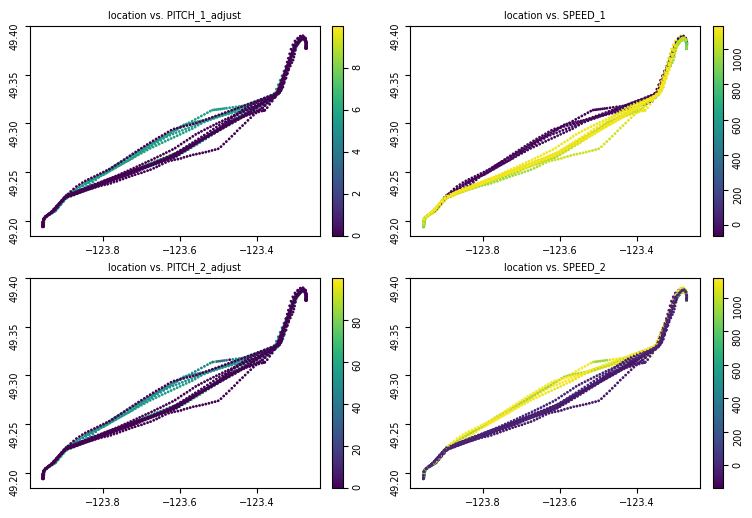

In [11]:
fig = plt.figure(figsize=(9,6))

fig.add_subplot(2,2,1)
plot_location(samples, "PITCH_1_adjust", s=1)
fig.add_subplot(222)
plot_location(samples, "SPEED_1", s=1)
fig.add_subplot(223)
plot_location(samples, "PITCH_2_adjust", s=1)
fig.add_subplot(224)
plot_location(samples, "SPEED_2", s=1)

fig.show()

In [102]:
df[df["SOG"] > df["STW"]][["SOG", "STW"]]

,SOG,STW
3,0.2150,0.1200
4,0.8833,0.6950
42,2.5417,1.9100
44,11.1550,10.9650
45,14.1650,14.0983
...,...,...
748881,13.7683,13.1350
748882,10.2017,8.5250
748883,6.4367,3.9233
748884,3.0883,2.1783


In [103]:
df[df["SOG"] < df["STW"]][["SOG", "STW"]]

,SOG,STW
0,0.0117,0.0283
1,0.0150,0.0467
2,0.0083,0.0467
5,0.0900,0.3733
6,0.0400,0.2250
...,...,...
748924,0.0000,0.2000
748925,0.0000,0.1900
748926,0.0000,0.1667
748927,0.1033,0.1867
